# 随机梯度下降和独热编码

## 介绍

不知不觉中，大数据时代已经到来。想象一下，如果你的训练数据集为 100G 或者更大，你在训练模型时，会怎么做呢？为了解释这个问题，本节将介绍什么是随机梯度下降算法，在线学习以及独热编码和哈希技巧。

## 知识点

- 随机梯度下降
- 在线学习
- 独热编码
- 哈希技巧

## 随机梯度下降

梯度下降是一种优化算法，因为其理解起来相对比较简单，所以梯度下降往往都是许多人在学习机器学习时最先接触到的优化算法。但它只是最基本的优化算法之一，在面对复杂的模型或数据时，很难达到较好的优化效果。

梯度下降的主要思想很简单，就是通过在下降最快的方向移动来逐步逼近某些函数的最小值。 一般情况下，增长最快的方向指的是某个函数点的偏导数所指的方向，也就是某个函数点的斜率。也就是说，如果通过向相反方向移动，也就是函数下降最快的方向，就可以以最快的速度找到函数的最小值。

<img src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034672266' width='450'>

梯度下降的想法就跟上图所示的滑雪运动一样。 如果你想尽可能快地到达山脚，你就需要选择最陡的下降路线。

### 实验例子



In [2]:
import warnings
import seaborn as sns
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

实验所用到的数据为 SOCR 数据集， 数据集记录的是每个人的体重和身高信息。

导入数据集。

In [3]:
data_demo = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/weights_heights.csv')  # 导入数据集
data_demo.head()

,Index,Height,Weight
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971


为了直观地看出体重与身高的关系，画出数据分布图。

Text(0, 0.5, 'Height in inches')

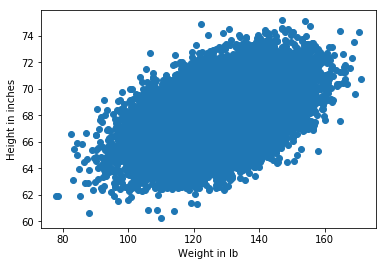

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height'])
plt.xlabel('Weight in lb')
plt.ylabel('Height in inches')

在这个数据集中，总共含有 $n$ 个样本，向量 $x$ 表示样本中每个人的重量，$y$ 则表示每个人的身高。假设 $x$ 与 $y$ 线性相关，则可以定义出一元线性回归模型：

 $$y_i = w_0 + w_1 x_i$$ 
 
 其中 $y_i$ 是 $i$ 身高值，$x_i$ 是 $i$ 体重值。
 
 模型训练的目标是：要找到一组权重值 $w_0$ 和 $w_1$ ，使得通过回归模型 $y_i = w_0 + w_1 x_i$ 预测出的身高与真实身高的平方差达到最小。用公式描述如下所示，下式中的 $SE(w_0，w_1)$ 也称为损失函数。
 
 $$SE(w_0, w_1) = \frac{1}{2}\sum_{i=1}^{n}(y_i - (w_0 + w_1x_{i}))^2 \rightarrow min_{w_0, w_1}$$
 
 在最小化损失函数的过程中。使用梯度下降算法来进行优化。利用 $SE(w_0，w_1)$ 对权重 $w_0$ 和 $w_1$ 求偏导数，然后通过下面所示的更新公式来对权值进行更新。其中，$\eta$ 为学习率：
 
 $$w_0^{(t+1)} = w_0^{(t)} -\eta \frac{\partial SE}{\partial w_0} |_{t}$$
 
 $$w_1^{(t+1)} = w_1^{(t)} -\eta \frac{\partial SE}{\partial w_1} |_{t} $$
 
 计算损失函数对权值的偏导数，将得到以下结果：
 
 $$ w_0^{(t+1)} = w_0^{(t)} + \eta \sum_{i=1}^{n}(y_i - w_0^{(t)} - w_1^{(t)}x_i)$$
 
 $$ w_1^{(t+1)} = w_1^{(t)} + \eta \sum_{i=1}^{n}(y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i$$
 
 关于梯度下降的数学运算过程在 [<i class="fa fa-external-link-square" aria-hidden="true"> 《深度学习》</i>](http://www.deeplearningbook.org/contents/numerical.html) 中的数值计算章节也得到了非常详尽的介绍。 
这里先不讨论局部最小值，鞍点，选择学习率和其他内容的问题。如果数据量不大的话，这个优化过程当然可以运行。但是，当训练样本很大时会发生什么呢？ 

显然，梯度下降存在一个问题，即梯度计算需要用到训练集中的每个样本。换句话说，该算法需要大量迭代才能找到最小值，并且每次迭代都需要使用训练样本的全部数据来进行运算。当训练数据集非常庞大时，则其将需要发费巨大的计算才能完成一次更新迭代。要训练一个模型，就要付出巨大的时间代价。

为了解决上述梯度下降存在的问题， 随机梯度下降算法被提出。相比于梯度下降算法，随机梯度下降每次迭代仅用一些小样本来进行运算，然后迭代更新权重，也就是每次迭代只从训练样本里抽取一部分数据，而不是所有的数据。这也极大的提高了计算效率，因为每次迭代的计算样本变少了。如果每次只取一个样本，则权重更新可表达为下式：

$$w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)$$

$$ w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i $$

当然，随机梯度下降算法也带来了一个问题。就是随机梯度下降并不能保证在每次迭代中都会朝着最佳的方向前进。因为每次迭代取的只是一小批数据，而这一小批数据并不一定等同于整体数据，通过这小批数据所计算得到的梯度方向不一定为全局的最佳方向。因此，可能需要更多的迭代才能收敛。吴恩达在他的 [<i class="fa fa-external-link-square" aria-hidden="true"> 机器学习课程</i>](https://www.coursera.org/learn/machine-learning) 中很好地说明了这一点。 

<img src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557033352168' width='400'>

上图是某函数的等值线图， $\theta_0$ 和 $\theta_1$ 对应于 $w_0$ 和 $w_1$ 。优化过程是找到此函数的全局最小值。 在随机梯度下降方法中，随着迭代次数的增加，权重的更新方向会更难预测，如图中的紫线所示。但是，不论是随机梯度下降还是梯度下降算法，最终结果都会收敛于同一个全局最小值点。而随机梯度下降算法则要快得多。

## 在线学习方法

随机梯度下降为训练具有高达数百 GB 的大量数据的分类器和回归器提供了实现途径。因为每次迭代只需要拿取小批量的数据，而不是全部数据，因此大大提高训练速度。但其仍然存在一个问题。如果训练数据为 100G 或者更大，对于现在的普通电脑来说，一次读取全部数据到内存是不可能的，会出现内存爆满的情况。

为解决这一问题，在线学习方法被提出，在线学习的思想是将训练数据集 $(X,y)$ 存储在电脑的硬盘中而不将其加载到运行内存中，然后在训练模型时逐个读取，并更新模型的权重：

$$w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)$$

$$w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i$$

这里我们不对随机梯度下降算法原理进行深入讨论，如果你感兴趣可以参考 [<i class="fa fa-external-link-square" aria-hidden="true"> 凸优化</i>](https://www.amazon.com/Convex-Optimization-Stephen-Boyd/dp/0521833787) 这本书。

在 scikit-learn 中，使用随机梯度下降算法来进行优化的分类器和回归器在 `sklearn.linear_model` 中，并命名为 `SGDClassifier` 和 `SGDRegressor`。

## 类别型特征处理

目前，许多分类和回归算法是在欧几里德空间中操作的。这意味着，输入数据特征要用数值表示。 但是，在实际数据中，往往包含离散的类别特征，例如：是/否或 1 月/ 2 月/ ... / 12 月。如果将这些类别型特征输入都模型中，模型可能无法运行。 那应该如何去处理这种类别型的数据呢？

为了解释说明这个问题。选择 UCI 的 [<i class="fa fa-external-link-square" aria-hidden="true"> bank marketing</i>](https://archive.ics.uci.edu/ml/datasets/bank+marketing) 数据集来进行实验，因为该数据集中大部分的特征均为类别型特征。先读取数据集。

In [5]:
df = pd.read_csv(
    'https://labfile.oss-cn-hangzhou.aliyuncs.com/courses/1283/bank_train.csv')
labels = pd.read_csv(
    'https://labfile.oss-cn-hangzhou.aliyuncs.com/courses/1283/bank_train_target.csv', header=None)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


从上表中，可以看到大多数特征都没有用数字表示。也就是说，不能将这些数据直接输入大多数机器学习模型。因此，要将类别型数据改为数值型数据。

先来分析 education 这个特征：

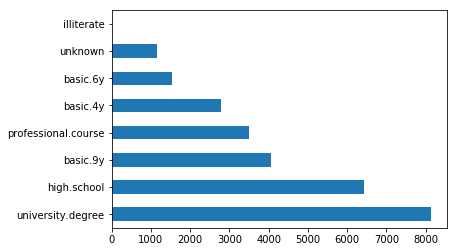

In [6]:
df['education'].value_counts().plot.barh()

将类别型数据转换成为数值型数据最直接的解决方法就是将此特征的每个值映射到一个唯一的数字。例如，可以将 university.degree 映射到 0 ，将 basic.9y 映射到 1，依此类推。 这里可以使用 `sklearn.preprocessing.LabelEncoder` 来执行此映射。

该类的 `fit` 方法会查找所有一列特征中的所有类别并构建类别和数字之间的映射，用 `transform` 方法将类别转换为数字。

{0: 'basic.4y',
 1: 'basic.6y',
 2: 'basic.9y',
 3: 'high.school',
 4: 'illiterate',
 5: 'professional.course',
 6: 'university.degree',
 7: 'unknown'}

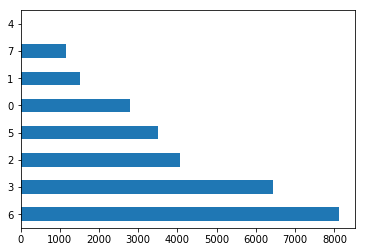

In [8]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
dict(enumerate(label_encoder.classes_))

In [10]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


用同样的方法转换数据集的其他类别型的特征。

In [11]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


这种方法存在一个问题，那就是会引入了一些可能不存在任何意义的相对排序。例如，在 job 这个特征的值中隐含地引入了代数，这可以从客户端 ＃1 的工作中减去客户端 ＃2 的工作：


In [12]:
df.loc[1].job - df.loc[2].job

-1.0

这个操作有意义吗？显然没有， 现在使用转换后的特征来训练逻辑回归模型。

In [13]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.values
    labels = np.array(labels)
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels.ravel())

    logit = LogisticRegression(max_iter=1000, solver='lbfgs')
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))


print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6166
           1       0.50      0.00      0.01       733

    accuracy                           0.89      6899
   macro avg       0.70      0.50      0.47      6899
weighted avg       0.85      0.89      0.84      6899



可以看到 1 类的召回率为 0 或接近于 0，这意味着模型几乎把数据都分给了 0 类。为了避免这个问题，这里将使用另一种转换方法：独热编码。

## 独热编码

独热编码又称为 One-Hot 编码，是用只含 0 和 1 来表示类别型特征的方法。假设某项特征含有三个类别值。独热编码会创建三个向量来表示这三个类别值，例如：[1,0,0]，[0,1,0]，[0,0,1]。来看一个例子。

In [14]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


在使用 One-Hot 编码时，可以直接调用 `sklearn.preprocessing.OneHotEncoder` 接口。 默认情况下，One-Hot 将数据转换为稀疏矩阵以节省内存空间，因为大多数值都是零。 但是，在本实验这个特定的例子中，因为数据量比较少，所以没有遇到内存爆满的问题，因此这里使用「稠密」矩阵表示。

In [16]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')

encoded_categorical_columns = pd.DataFrame(
    onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


在进行 One-Hot 编码之后，得到 53 列数据，分别对应于原数据集类别特征的唯一值。

In [17]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6109
           1       0.64      0.17      0.27       790

    accuracy                           0.89      6899
   macro avg       0.77      0.58      0.61      6899
weighted avg       0.87      0.89      0.87      6899



由上面的结果可知， 1 类的召回率得到了改善。

## 哈希技巧

在实际的工程应用中，真实数据可能是不稳定的，也就是说我们无法保证一些类别特征不会出现新的值。 此问题可能会导致训练好的模型无法使用。 除此之外，类别编码需要对整个数据集进行分析，并在内存中构建映射，这使得处理大型数据集变得尤为困难。

有一种基于哈希的类别编码方法，并且被称为哈希技巧。哈希函数将类别型特征编码为不同的特征值，例如：

In [18]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '→', hash(s))

university.degree → 2305780839657966817
high.school → -8948242433271907169
illiterate → 5729106403706481059


一般情况下，在哈希函数中，我们不使用负数值以及比较大的数值，所以要将哈希值限定在一个范围空间。

In [19]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '→', hash(s) % hash_space)

university.degree → 17
high.school → 6
illiterate → 9


哈希编码也可以创建类似于 One-Hot 编码的向量。可以看下面这个例子：

In [20]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '→', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student → 10
marital=single → 11
day_of_week=mon → 14


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


这里需要指出的是，哈希编码不仅需要散列特征值，也需要散列「特征名称 + 特征值」对。 因为这样可以区分不同特征的相同值。

In [21]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')


使用哈希编码时是否可能发生冲突？ 当然，这是可能的。不过只要哈希空间足够大，这个问题可以避免。 但一般情况下，即使发生冲突，回归或分类指标也不会受到太大影响。 在这种情况下，哈希冲突可作为正则化的一种形式。

你可能在说：WTF，哈希似乎违反直觉。但事实上，有时这是唯一可行的处理类别数据的方法。 而且，这种技术已被证明是有效的。等你处理了足够多的数据之后，你可能自己意识到这一点。